# 🧠 Homework: Implementing a Kohonen Self-Organizing Map (SOM)

In this assignment, you’ll implement a **Self-Organizing Map (SOM)** — an unsupervised neural network that projects high-dimensional data onto a low-dimensional (typically 2D) grid.

You will:
1. Implement key functions of the SOM algorithm from scratch.
2. Train your SOM on both **synthetic 2D data** and **GloVe word embeddings**.
3. Observe how similar data points cluster on the 2D map.

---

### ✏️ Your Tasks:
You’ll complete parts of the following methods inside the `KohonenSOM` class:
- `__init__`: random weight initialization  
- `_find_bmu`: find the Best Matching Unit (BMU)  
- `_neighborhood`: compute the neighborhood influence  
- weight update rule inside `train`  


In [ ]:
!pip install gensim

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.datasets import make_blobs
from gensim.downloader import load


### 🧱 Purpose
In this cell, you'll define the `KohonenSOM` class, which implements the Self-Organizing Map.

You will fill in the main parts of the algorithm:
1. **Initialize the weights** randomly  
2. **Find the BMU** — the neuron whose weights are closest to the input  
3. **Compute the neighborhood** — how much neighboring neurons should be updated  
4. **Update the weights** based on the BMU and neighborhood influence

We’ve already implemented:
- Normalization and learning rate decay  
- Shuffling and iteration structure  
- Mapping functions for visualization

Focus only on the core algorithmic logic in the `TODO` sections.


In [ ]:
class KohonenSOM:
    def __init__(self, x_size, y_size, input_len, learning_rate=0.5, sigma=None, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.x_size = x_size
        self.y_size = y_size
        self.input_len = input_len
        self.learning_rate0 = learning_rate
        self.sigma0 = sigma if sigma is not None else max(x_size, y_size) / 2.0

        # 🧩 TODO: Initialize the SOM weights randomly between 0 and 1
        self.weights = np.random.rand(x_size,y_size,input_len)

        # Create coordinate grid for neurons
        self.xx, self.yy = np.meshgrid(np.arange(x_size), np.arange(y_size), indexing="ij")

    def _find_bmu(self, x):
        """
        🧩 TODO: Compute the Best Matching Unit (BMU)
        Input: x (1D numpy array)
        Output: (i, j) index of the neuron whose weight is closest to x
        """
        diff = self.weights - x
        dists = np.linalg.norm(diff,axis=2)
        return np.unravel_index(np.argmin(dists),dists.shape)


    def _neighborhood(self, bmu, sigma):
        """
        🧩 TODO: Compute Gaussian neighborhood centered at the BMU.
        Output: matrix of shape (x_size, y_size)
        """
        dist = (self.xx - bmu[0])**2 + (self.yy - bmu[1])**2
        return np.exp(-dist / (2 * sigma**2))

    def train(self, data, num_epochs=100, verbose=True):
        data = np.asarray(data, dtype=float)
        mean = data.mean(axis=0)
        std = data.std(axis=0) + 1e-9
        data = (data - mean) / std

        T = float(num_epochs)
        for epoch in range(num_epochs):
            # Decaying learning rate and sigma (already implemented)
            lr = self.learning_rate0 * (1 - epoch / T)
            sigma = self.sigma0 * (1 - epoch / T)
            sigma = max(sigma, 0.5)

            # Shuffle data for online updates
            for x in data[np.random.permutation(len(data))]:
                # --- 🧠 Find the BMU ---
                bmu = self._find_bmu(x)

                # --- 🧠 Compute neighborhood influence ---
                neigh = self._neighborhood(bmu, sigma)[..., np.newaxis]

                # --- 🧩 TODO: Update the weights ---
                self.weights += lr * neigh * (x - self.weights)

            if verbose and ((epoch + 1) % (num_epochs // 10) == 0 or epoch == 0):
                print(f"Epoch {epoch+1}/{num_epochs} lr={lr:.3f} sigma={sigma:.3f}")

        self.mean = mean
        self.std = std

    def map_vectors(self, data):
        data = np.asarray(data, dtype=float)
        data = (data - self.mean) / self.std
        bmus = []
        for x in data:
            bmus.append(self._find_bmu(x))
        return bmus

    def get_weights_original_scale(self):
        return self.weights * self.std.reshape(1, 1, -1) + self.mean.reshape(1, 1, -1)


### 🎨 Purpose
Before testing on real-world embeddings, let’s verify that your SOM works correctly on simple 2D data.

In this experiment:
- We generate 500 synthetic data points using `make_blobs`.
- We train a SOM to represent these points.
- If your implementation is correct, the neuron grid (red points connected by lines) should **stretch over and cover** all the data clusters.


Epoch 1/100 lr=0.600 sigma=5.000
Epoch 10/100 lr=0.546 sigma=4.550
Epoch 20/100 lr=0.486 sigma=4.050
Epoch 30/100 lr=0.426 sigma=3.550
Epoch 40/100 lr=0.366 sigma=3.050
Epoch 50/100 lr=0.306 sigma=2.550
Epoch 60/100 lr=0.246 sigma=2.050
Epoch 70/100 lr=0.186 sigma=1.550
Epoch 80/100 lr=0.126 sigma=1.050
Epoch 90/100 lr=0.066 sigma=0.550
Epoch 100/100 lr=0.006 sigma=0.500
(10, 10, 2)


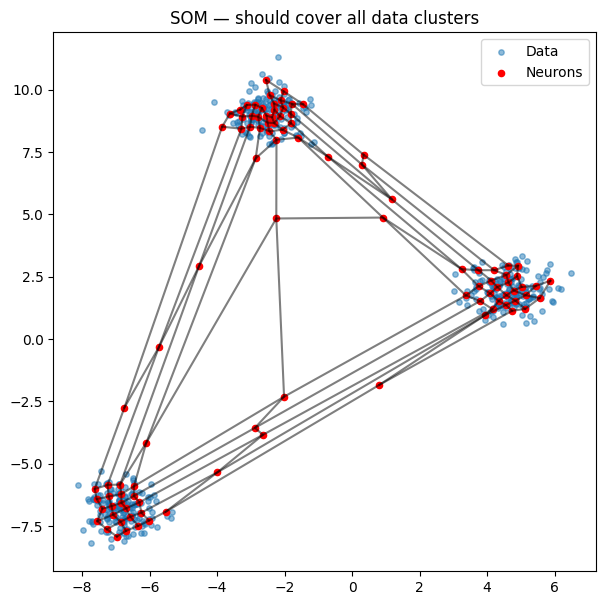

In [ ]:
# Generate a simple 2D dataset
data2d, _ = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=42)

# Create and train the SOM
som2 = KohonenSOM(x_size=10, y_size=10, input_len=2, learning_rate=0.6, sigma=5.0, seed=42)
som2.train(data2d, num_epochs=100)

# Visualize results
weights2d = som2.get_weights_original_scale()
plt.figure(figsize=(7,7))
plt.scatter(data2d[:,0], data2d[:,1], s=15, alpha=0.5, label="Data")
# Draw grid lines
for i in range(som2.x_size):
    plt.plot(weights2d[i,:,0], weights2d[i,:,1], 'k-', alpha=0.5)
for j in range(som2.y_size):
    plt.plot(weights2d[:,j,0], weights2d[:,j,1], 'k-', alpha=0.5)

plt.scatter(weights2d[:,:,0], weights2d[:,:,1], color='red', s=20, label="Neurons")
plt.title("SOM — should cover all data clusters")
plt.legend()
plt.show()


### 🗣️ Purpose
Now you’ll use your SOM to cluster **GloVe word embeddings**.

Each word is represented as a 100-dimensional vector capturing its semantic meaning.  
Your SOM should organize related words (e.g., “king”, “queen”, “man”, “woman”) into nearby cells.

Steps:
1. Load GloVe embeddings using `gensim.downloader`.
2. Select a small vocabulary of words.
3. Train your SOM on these embeddings.
4. Visualize how words are organized on the 2D grid.


In [11]:
print("Loading GloVe embeddings...")
glove = load("glove-wiki-gigaword-100")


Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded


In [15]:
words = [
    'king', 'queen', 'man', 'woman', 'boy', 'girl',
    'apple', 'orange', 'banana', 'grape', 'fruit', 'lemon',
    'car', 'bus', 'train', 'vehicle', 'road', 'driver',
    'dog', 'cat', 'horse', 'animal', 'pet', 'cow',
    'computer', 'internet', 'data', 'phone', 'music', 'movie'
]

words = [w for w in words if w in glove]
embeddings = np.array([glove[w] for w in words])
print(f"Loaded {len(words)} words.")

Loaded 30 words.


Epoch 1/200 lr=0.400 sigma=5.000
Epoch 20/200 lr=0.362 sigma=4.525
Epoch 40/200 lr=0.322 sigma=4.025
Epoch 60/200 lr=0.282 sigma=3.525
Epoch 80/200 lr=0.242 sigma=3.025
Epoch 100/200 lr=0.202 sigma=2.525
Epoch 120/200 lr=0.162 sigma=2.025
Epoch 140/200 lr=0.122 sigma=1.525
Epoch 160/200 lr=0.082 sigma=1.025
Epoch 180/200 lr=0.042 sigma=0.525
Epoch 200/200 lr=0.002 sigma=0.500


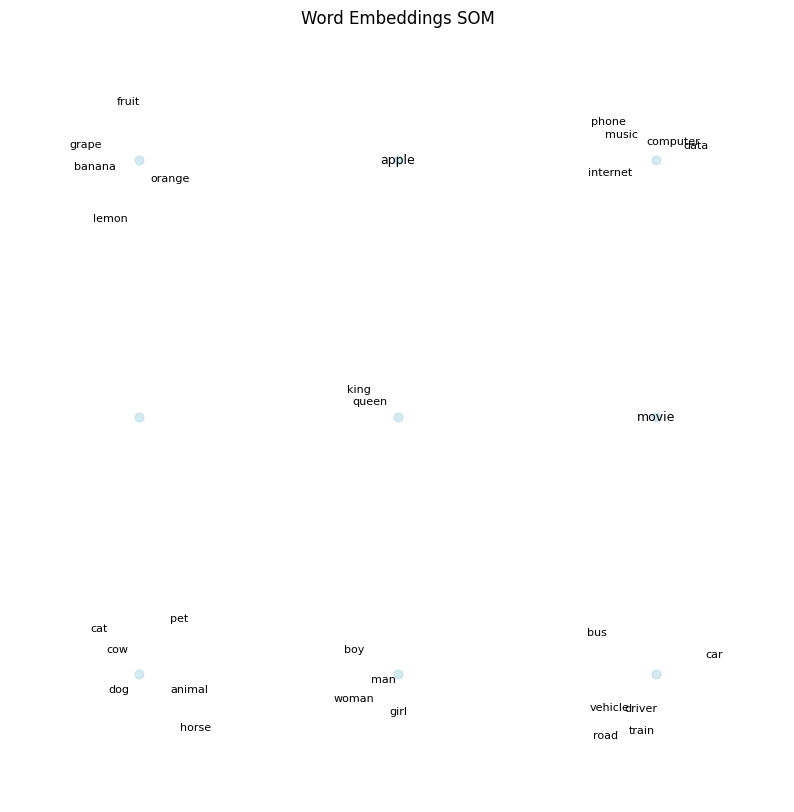

In [20]:


som_glove = KohonenSOM(x_size=3, y_size=3, input_len=embeddings.shape[1],
                       learning_rate=0.4, sigma=5.0, seed=42)
som_glove.train(embeddings, num_epochs=200)

word_positions = {w: pos for w, pos in zip(words, som_glove.map_vectors(embeddings))}

# Plot grid and word clusters
plt.figure(figsize=(10,10))
plt.title("Word Embeddings SOM")

for x in range(som_glove.x_size):
    for y in range(som_glove.y_size):
        plt.scatter(x + 0.5, y + 0.5, s=40, color='lightblue', alpha=0.5)

cell_words = defaultdict(list)
for w, (i, j) in word_positions.items():
    cell_words[(i, j)].append(w)

for (i, j), ws in cell_words.items():
    if len(ws) == 1:
        plt.text(i + 0.5, j + 0.5, ws[0], fontsize=9, ha='center', va='center')
    else:
        for k, w in enumerate(ws):
            jitter_x = np.random.uniform(-0.25, 0.25)
            jitter_y = np.random.uniform(-0.25, 0.25)
            plt.text(i + 0.5 + jitter_x, j + 0.5 + jitter_y, w, fontsize=8, ha='center', va='center')

plt.xlim(0, som_glove.x_size)
plt.ylim(0, som_glove.y_size)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()


### 🧭 Purpose
Reflect on your implementation and analyze what you’ve observed.

Answer these questions in your notebook after training your SOM:

1. What role does the **neighborhood function** play in shaping the SOM?
2. What happens if you increase the grid size (e.g. from 3×3 to 7×7)?
3. What semantic relationships did you observe between words in the map?
